In [39]:
# Import the required libraries
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TimeDistributed, Flatten, LSTM, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random
import albumentations as A
import gc

In [40]:
# Set random seeds for reproducibility
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [46]:
# Constants
DATASET_DIR = "/kaggle/input/ucf-50/UCF50"
NO_OF_CLASSES = 12
CLASSES_LIST = os.listdir(DATASET_DIR)[:NO_OF_CLASSES]
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
SEQUENCE_LENGTH = 15
DROPOUT_RATE = 0.3
MAX_VIDEO_PER_CLASS = 20
TEST_SIZE = 0.20
EPOCHS = 50
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.20
MODEL_NAME = "Xception"

In [48]:
# Verify dataset directory exists
assert os.path.exists(DATASET_DIR), f"Dataset directory not found: {DATASET_DIR}"

In [49]:
# Data Preparation Functions
def resize_and_normalize_frame(frame, image_height, image_width):
    """Resize and normalize a single frame."""
    try:
        resized_frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_LINEAR)
        normalized_frame = resized_frame / 255.0
        return normalized_frame
    except Exception as e:
        print(f"Error processing frame: {e}")
        return None

def frames_extraction(video_path, sequence_length=SEQUENCE_LENGTH, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH):
    """Extract and process frames from a video."""
    frames_list = []
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None
    video_reader = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        video_reader.release()
        return None
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    if video_frames_count < sequence_length:
        print(f"Warning: Video {video_path} has only {video_frames_count} frames, less than required {sequence_length}")
        video_reader.release()
        return None
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)
    frame_indices = [i * skip_frames_window for i in range(sequence_length)]
    frames = []
    for idx in frame_indices:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = video_reader.read()
        if not success or frame is None:
            print(f"Warning: Failed to read frame at index {idx} from {video_path}")
            break
        frames.append(frame)
    video_reader.release()
    if len(frames) != sequence_length:
        print(f"Warning: Read {len(frames)} frames instead of {sequence_length} from {video_path}")
        return None
    with ThreadPoolExecutor() as executor:
        processed_frames = list(executor.map(
            lambda f: resize_and_normalize_frame(f, image_height, image_width), frames))
    if any(f is None for f in processed_frames):
        print(f"Warning: Some frames failed to process in {video_path}")
        return None
    return np.array(processed_frames, dtype=np.float32)

def create_dataset(dataset_dir, classes_list, sequence_length=SEQUENCE_LENGTH, image_height=IMAGE_HEIGHT,
                   image_width=IMAGE_WIDTH, max_videos_per_class=None, augmentations=False):
    """Create dataset from video frames."""
    features, labels = [], []
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")
    for class_index, class_name in enumerate(classes_list):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Class directory not found: {class_path}")
            continue
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(class_path)
        if max_videos_per_class is not None:
            files_list = files_list[:max_videos_per_class]
        for file_name in files_list:
            video_file_path = os.path.join(class_path, file_name)
            frames = frames_extraction(video_file_path, sequence_length, image_height, image_width)
            if frames is None:
                print(f"Skipping video {video_file_path} due to frame extraction failure")
                continue
            features.append(frames)
            labels.append(class_index)
    if not features:
        raise ValueError("No valid videos were processed. Check dataset or parameters.")
    features = np.asarray(features)
    labels = np.array(labels)
    print(f"Dataset created with {len(features)} videos")
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    return features, labels, np.array([]), np.array([])  # No augmentation for now

In [50]:
# Augmentation Functions
def validate_frame(frame):
    if not isinstance(frame, np.ndarray) or len(frame.shape) != 3 or frame.shape[2] != 3 or frame.shape[0] < 1 or frame.shape[1] < 1:
        raise ValueError(f"Invalid frame shape {frame.shape}")
    return frame

def horizontal_flip_frame(frame):
    try:
        frame = validate_frame(frame).astype(np.uint8)
        return tf.image.flip_left_right(tf.convert_to_tensor(frame, dtype=tf.uint8)).numpy()
    except Exception as e:
        print(f"Error in horizontal_flip_frame: {e}")
        raise

def random_shear_frame(frame):
    try:
        frame = validate_frame(frame).astype(np.uint8)
        frame_tensor = tf.convert_to_tensor(frame, dtype=tf.float32)
        shear_x = np.random.uniform(-0.09, 0.09)
        shear_y = np.random.uniform(0.1, 0.3)
        return tf.keras.preprocessing.image.apply_affine_transform(
            tf.expand_dims(frame_tensor, 0), shear=np.degrees(np.arctan(shear_y)), fill_mode='bilinear'
        ).numpy().squeeze().astype(np.uint8)
    except Exception as e:
        print(f"Error in random_shear_frame: {e}")
        raise

def salt_and_pepper_noise_frame(frame, amount=0.02):
    try:
        frame = validate_frame(frame).astype(np.uint8)
        frame_tensor = tf.convert_to_tensor(frame, dtype=tf.float32)
        total_pixels = frame.shape[0] * frame.shape[1]
        noise_mask = tf.ones_like(frame_tensor)
        salt_coords = tf.random.uniform([int(total_pixels * amount), 2], [0, frame.shape[0]], dtype=tf.int32)
        noise_mask = tf.tensor_scatter_nd_update(noise_mask, tf.concat([salt_coords, tf.repeat(tf.range(3)[None, :], len(salt_coords), axis=0)], axis=1), tf.fill([len(salt_coords), 3], 255.0))
        pepper_coords = tf.random.uniform([int(total_pixels * amount), 2], [0, frame.shape[0]], dtype=tf.int32)
        noise_mask = tf.tensor_scatter_nd_update(noise_mask, tf.concat([pepper_coords, tf.repeat(tf.range(3)[None, :], len(pepper_coords), axis=0)], axis=1), tf.zeros([len(pepper_coords), 3]))
        return tf.where(noise_mask != 1, noise_mask, frame_tensor).numpy().astype(np.uint8)
    except Exception as e:
        print(f"Error in salt_and_pepper_noise_frame: {e}")
        raise

def apply_augmentation(frames, augmentation_func):
    with ThreadPoolExecutor() as executor:
        return list(executor.map(augmentation_func, frames))

def horizontal_flip(frames): return apply_augmentation(frames, horizontal_flip_frame)
def random_shear_frames(frames): return apply_augmentation(frames, random_shear_frame)
def salt_and_pepper_noise_frames(frames): return apply_augmentation(frames, lambda x: salt_and_pepper_noise_frame(x, 0.02))

In [51]:
# Data Generator
class VideoDataGenerator(Sequence):
    def __init__(self, video_frames, labels, batch_size, augmentations=False):
        self.video_frames = [np.array(seq, dtype=np.float32) for seq in video_frames]
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.indices = np.arange(len(self.video_frames))
        self.augmentations = augmentations
        if self.augmentations:
            self.random_shear = A.Compose([A.Affine(shear={'x': (-10, 10), 'y': (-10, 10)}, mode='constant', cval=0, p=1.0)])
            self.horizontal_flip = A.Compose([A.HorizontalFlip(p=1.0)])
            self.salt_pepper_noise = A.Compose([A.GaussNoise(var_limit=(0.001, 0.005), mean=0, p=1.0)])

    def __len__(self):
        return int(np.ceil(len(self.video_frames) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        if len(batch_indices) == 0:
            return np.array([]), np.array([])
        batch_video_frames = [self.video_frames[i] for i in batch_indices]
        batch_labels = self.labels[batch_indices]
        all_frames, all_labels = [], []
        for i, sequence in enumerate(batch_video_frames):
            all_frames.append(sequence)
            all_labels.append(batch_labels[i])
            if self.augmentations:
                for aug in [self.random_shear, self.horizontal_flip, self.salt_pepper_noise]:
                    aug_sequence = np.zeros_like(sequence)
                    for t in range(sequence.shape[0]):
                        aug_frame = aug(image=sequence[t])['image']
                        aug_sequence[t] = aug_frame
                    all_frames.append(aug_sequence)
                    all_labels.append(batch_labels[i])
        return np.array(all_frames, dtype=np.float32), np.array(all_labels)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

    def as_dataset(self):
        def generator():
            for idx in range(len(self)):
                frames, labels = self[idx]
                if frames.size == 0:
                    continue
                yield frames, labels
        return tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.float32),
            output_shapes=([None, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3], [None, NO_OF_CLASSES])
        ).prefetch(tf.data.AUTOTUNE)

In [52]:
# Create and Prepare Dataset
try:
    features, labels, _, _ = create_dataset(
        dataset_dir=DATASET_DIR, classes_list=CLASSES_LIST, max_videos_per_class=MAX_VIDEO_PER_CLASS, augmentations=True
    )
except Exception as e:
    print(f"Error: {e}")
    raise
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size=TEST_SIZE, shuffle=True, random_state=seed_constant
)
train_video_frames, val_video_frames = features_train[:int(0.8 * len(features_train))], features_train[int(0.8 * len(features_train)):]
train_labels, val_labels = labels_train[:int(0.8 * len(labels_train))], labels_train[int(0.8 * len(labels_train)):]

Extracting Data of Class: HorseRace
Extracting Data of Class: VolleyballSpiking
Extracting Data of Class: Biking
Extracting Data of Class: TaiChi
Extracting Data of Class: Punch
Extracting Data of Class: BreastStroke
Extracting Data of Class: Billiards
Extracting Data of Class: PoleVault
Extracting Data of Class: ThrowDiscus
Extracting Data of Class: BaseballPitch
Extracting Data of Class: HorseRiding
Extracting Data of Class: Mixing
Dataset created with 240 videos
Features shape: (240, 15, 224, 224, 3)
Labels shape: (240,)


In [53]:
# Create Generators
train_gen = VideoDataGenerator(train_video_frames, train_labels, BATCH_SIZE, augmentations=True)
val_gen = VideoDataGenerator(val_video_frames, val_labels, BATCH_SIZE)

/tmp/ipykernel_35/3323116968.py:10: UserWarning: Argument(s) 'mode, cval' are not valid for transform Affine
  self.random_shear = A.Compose([A.Affine(shear={'x': (-10, 10), 'y': (-10, 10)}, mode='constant', cval=0, p=1.0)])
/tmp/ipykernel_35/3323116968.py:12: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  self.salt_pepper_noise = A.Compose([A.GaussNoise(var_limit=(0.001, 0.005), mean=0, p=1.0)])


In [54]:
# Clear memory
del features, labels, features_train, labels_train, train_video_frames, train_labels, val_video_frames, val_labels
gc.collect()

117

In [55]:
# Model Creation
def create_xception_lstm_model(sequence_length, image_height, image_width, classes_list):
    try:
        print("Loading Xception base model...")
        xception = Xception(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
        for layer in xception.layers:
            layer.trainable = False
        for layer in xception.layers[-10:]:
            layer.trainable = True
        model = Sequential([
            TimeDistributed(xception, input_shape=(sequence_length, image_height, image_width, 3)),
            TimeDistributed(GlobalAveragePooling2D()),
            LSTM(128, activation="tanh", return_sequences=False),
            Dropout(DROPOUT_RATE),
            Dense(len(classes_list), activation="softmax")
        ])
        print("Model architecture created successfully!")
        model.summary()
        return model
    except Exception as e:
        print(f"Error creating model: {e}")
        return None

In [56]:
# Pre-load Xception weights
print("Pre-loading Xception weights...")
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
print("Weights loaded successfully!")

Pre-loading Xception weights...
Weights loaded successfully!


In [57]:
# Clear session and create model
tf.keras.backend.clear_session()
gc.collect()
xlstm_model = create_xception_lstm_model(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CLASSES_LIST)
if xlstm_model is None:
    raise ValueError("Model creation failed")
plot_model(xlstm_model, to_file=f'{MODEL_NAME}_model_Plot.png', show_shapes=True, show_layer_names=True)
print(f"{MODEL_NAME} Model Plot saved successfully...")

Loading Xception base model...
Model architecture created successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 15, 7, 7, 2048)      │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 15, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │       1,114,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,977,652 (83.84 MB)

 Trainable params: 6,612,492 (25.22 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

Xception Model Plot saved successfully...


In [58]:
# Compile and Train Model
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=7, mode='min', restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
xlstm_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
xlstm_model_training_history = xlstm_model.fit(
    train_gen.as_dataset(), epochs=EPOCHS, validation_data=val_gen.as_dataset(),
    callbacks=[early_stopping_callback, lr_scheduler], verbose=1
)

Epoch 1/50
     20/Unknown 112s 1s/step - accuracy: 0.2509 - loss: 2.3257

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.2555 - loss: 2.3193 - val_accuracy: 0.6154 - val_loss: 1.6127 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8454 - loss: 1.2070 - val_accuracy: 0.8718 - val_loss: 0.8331 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9342 - loss: 0.5954 - val_accuracy: 0.8974 - val_loss: 0.5500 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9872 - loss: 0.2782 - val_accuracy: 0.8974 - val_loss: 0.4668 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9842 - loss: 0.1539 - val_accuracy: 0.8974 - val_loss: 0.4583 - learning_rate: 1.0000e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9988 - loss: 0.0842 - val_accuracy: 0.8974 - val_loss: 0.4299 - learning_rate: 1.0000e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 1.0000 - loss: 0.0514 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
Classification Report:
                   precision    recall  f1-score   support

        HorseRace       0.80      1.00      0.89         4
VolleyballSpiking       0.75      1.00      0.86         3
           Biking       1.00      1.00      1.00         5
           TaiChi       1.00      0.83      0.91         6
            Punch       1.00      1.00      1.00         4
     BreastStroke       1.00      1.00      1.00         5
        Billiards       1.00      1.00      1.00         5
        PoleVault       0.67      1.00      0.80         4
      ThrowDiscus       1.00      0.40      0.57         5
    BaseballPitch       1.00      1.00      1.00         2
      HorseRiding       1.00      1.00      1.00         3
           Mixing       1.00      1.00      1.00         2

         accuracy                           0.92        48
        macro avg       0.93      0.94      0.92        48
     weighted avg       0.94      0.92      0.91    

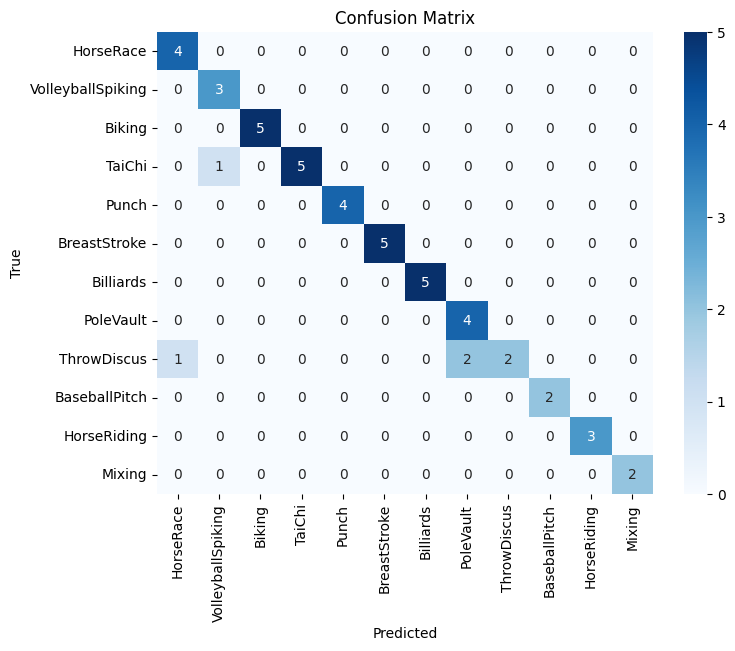

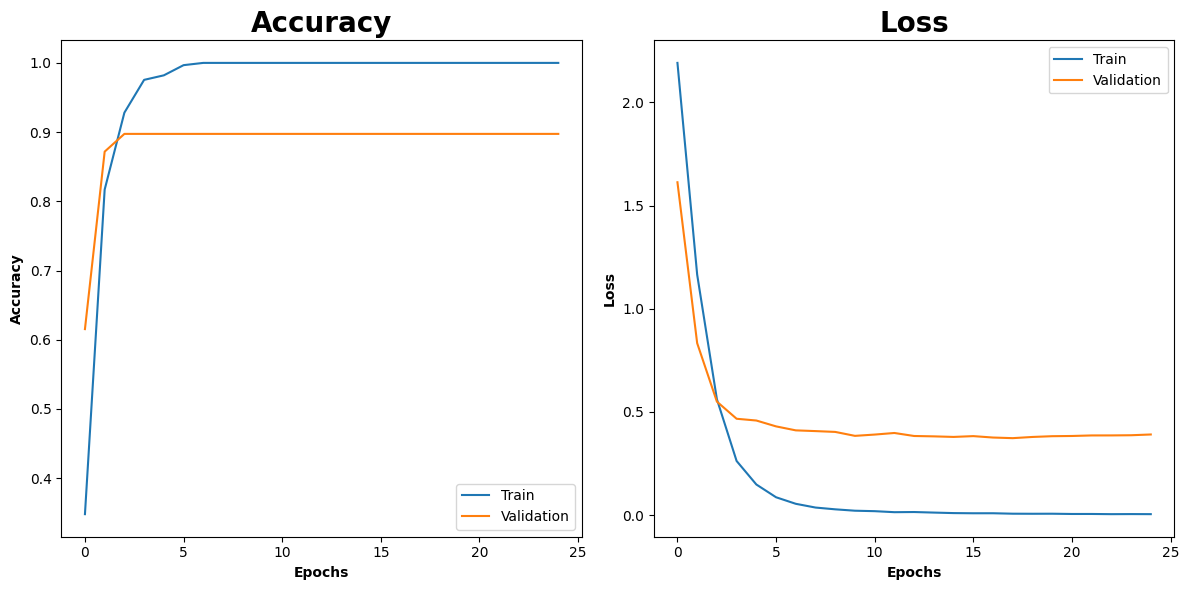

In [59]:
# Evaluate and Visualize
test_gen = VideoDataGenerator(features_test, labels_test, batch_size=len(features_test))
predictions = xlstm_model.predict(test_gen.as_dataset())
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test, axis=1)
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=CLASSES_LIST))

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Accuracy", weight="bold", fontsize=20)
plt.plot(xlstm_model_training_history.history["accuracy"])
plt.plot(xlstm_model_training_history.history["val_accuracy"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.subplot(1, 2, 2)
plt.title("Loss", weight="bold", fontsize=20)
plt.plot(xlstm_model_training_history.history["loss"])
plt.plot(xlstm_model_training_history.history["val_loss"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.tight_layout()
plt.show()

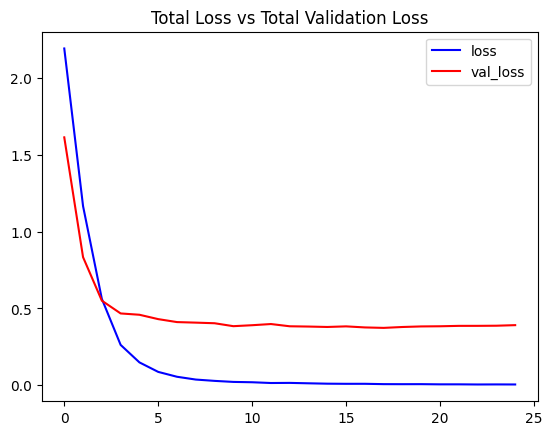

In [60]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    """Plot training and validation metrics."""
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
    plt.title(plot_name)
    plt.legend()
    plt.show()

plot_metric(xlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [61]:
# Evaluate model
test_dataset = tf.data.Dataset.from_tensor_slices((features_test, labels_test)).batch(BATCH_SIZE)
model_evaluation_history = xlstm_model.evaluate(test_dataset)
print(f"Test Loss: {model_evaluation_history[0]}, Test Accuracy: {model_evaluation_history[1]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 406ms/step - accuracy: 0.8985 - loss: 0.2844
Test Loss: 0.21500973403453827, Test Accuracy: 0.9166666865348816
